In [99]:
# Import libraries
import pandas as pd
import numpy as np
import math
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.pyplot import figure
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor


# Turn off Warnings
warnings.filterwarnings("ignore")

In [66]:
# Read in full Motor Vehicle Collision Dataset
mvc_df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes.csv')

# Add Column identifying YEAR
mvc_df['YEAR'] = mvc_df['CRASH DATE'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').year)

# Filter to only use the last 5 years of data
mvc_df = mvc_df[mvc_df['YEAR'] > 2018]

# Drop Columns not used for this analysis
mvc_df.drop(['ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 
             'CROSS STREET NAME', 'OFF STREET NAME', 'COLLISION_ID', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED'], axis=1, inplace=True)

In [67]:
# Cleanup NA data
mvc_df['NUMBER OF PERSONS INJURED'].fillna(0, inplace=True)
mvc_df['NUMBER OF PERSONS KILLED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF PEDESTRIANS INJURED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF PEDESTRIANS KILLED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF CYCLIST INJURED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF CYCLIST KILLED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF MOTORIST INJURED'].fillna(0, inplace=True)
#mvc_df['NUMBER OF MOTORIST KILLED'].fillna(0, inplace=True)
mvc_df['BOROUGH'].fillna('UNKNOWN', inplace=True)

mvc_df['CRASH DATE'] = pd.to_datetime(mvc_df['CRASH DATE'])
mvc_df['CRASH HOUR'] = pd.to_datetime(mvc_df['CRASH TIME']).dt.hour
mvc_df['DAY OF WEEK'] = mvc_df['CRASH DATE'].dt.day_of_week

# Add Columns representing if collission resulted in Injury or Fatality
mvc_df['HAS INJURY'] = mvc_df['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if (x > 0) else 0)
mvc_df['HAS FATALITY'] = mvc_df['NUMBER OF PERSONS KILLED'].apply(lambda x: 1 if (x > 0) else 0)

# Function for finding the number of vehicles invovled in the collission
def num_vehicles_invovled(x):
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 2'])== True):
        return 1
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 2']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 3']) == True):
        return 2
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 3']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 4']) == True):
        return 3
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 4']) == False and pd.isna(x['CONTRIBUTING FACTOR VEHICLE 5']) == True):
        return 4
    if(pd.isna(x['CONTRIBUTING FACTOR VEHICLE 5']) == False):
        return 5

# Create new Column for number of cars involved
mvc_df['CARS INVOLVED'] = mvc_df.apply(lambda x: num_vehicles_invovled(x), axis=1)

mvc_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,...,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,YEAR,CRASH HOUR,DAY OF WEEK,HAS INJURY,HAS FATALITY,CARS INVOLVED
0,2021-09-11,2:39,UNKNOWN,2.0,0.0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,...,Sedan,NaN,NaN,NaN,2021,2,5,1,0,2
1,2022-03-26,11:45,UNKNOWN,1.0,0.0,Pavement Slippery,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022,11,5,1,0,1
2,2022-06-29,6:55,UNKNOWN,0.0,0.0,Following Too Closely,Unspecified,NaN,NaN,NaN,...,Pick-up Truck,NaN,NaN,NaN,2022,6,2,0,0,2
3,2021-09-11,9:35,BROOKLYN,0.0,0.0,Unspecified,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2021,9,5,0,0,1
4,2021-12-14,8:13,BROOKLYN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2021,8,1,0,0,1


In [87]:
# Create 1 Car Accident Dataframe
mvc_1_car = mvc_df[mvc_df['CARS INVOLVED'] == 1]
mvc_1_car.drop(['CRASH DATE','CRASH TIME','CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',  'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], axis=1, inplace=True)

mvc_1_car['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified', inplace=True)
mvc_1_car['VEHICLE TYPE CODE 1'].fillna('Unspecified', inplace=True)

# DO WE DROP UNSPECIFIED??
mvc_1_car['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()


Unspecified                                              69090
Driver Inattention/Distraction                           16675
Failure to Yield Right-of-Way                             9594
Unsafe Speed                                              2867
Other Vehicular                                           2545
Backing Unsafely                                          2543
Reaction to Uninvolved Vehicle                            1905
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     1792
Driver Inexperience                                       1644
Pavement Slippery                                         1630
Alcohol Involvement                                       1375
View Obstructed/Limited                                   1133
Traffic Control Disregarded                                879
Turning Improperly                                         796
Passing Too Closely                                        688
Passing or Lane Usage Improper                         

In [60]:
# Create 2 Car Accident Dataframe
mvc_2_car = mvc_df[mvc_df['CARS INVOLVED'] == 1]
mvc_2_car.drop(['CRASH DATE','CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], axis=1, inplace=True)
mvc_2_car.head()

mvc_2_car['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified', inplace=True)
mvc_2_car['VEHICLE TYPE CODE 1'].fillna('Unspecified', inplace=True)
mvc_2_car['CONTRIBUTING FACTOR VEHICLE 2'].fillna('Unspecified', inplace=True)
mvc_2_car['VEHICLE TYPE CODE 2'].fillna('Unspecified', inplace=True)

mvc_2_car.head()


,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,YEAR,CRASH HOUR,DAY OF WEEK,HAS INJURY,HAS FATALITY,CARS INVOLVED
1,11:45,UNKNOWN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,Unspecified,Sedan,Unspecified,2022,11,5,1,0,1
3,9:35,BROOKLYN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,Sedan,Unspecified,2021,9,5,0,0,1
4,8:13,BROOKLYN,0.0,0.0,0,0,0,0,0,0,Unspecified,Unspecified,Unspecified,Unspecified,2021,8,1,0,0,1
13,0:59,UNKNOWN,0.0,0.0,0,0,0,0,0,0,Unsafe Speed,Unspecified,Sedan,Unspecified,2021,0,1,0,0,1
16,20:03,BROOKLYN,4.0,0.0,0,0,0,0,4,0,Steering Failure,Unspecified,Sedan,Unspecified,2021,20,1,1,0,1


In [61]:
# Create 3 Car Accident Dataframe
mvc_3_car = mvc_df[mvc_df['CARS INVOLVED'] == 1]
mvc_3_car.drop(['CRASH DATE', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], axis=1, inplace=True)
mvc_3_car.head()

mvc_3_car['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified', inplace=True)
mvc_3_car['VEHICLE TYPE CODE 1'].fillna('Unspecified', inplace=True)
mvc_3_car['CONTRIBUTING FACTOR VEHICLE 2'].fillna('Unspecified', inplace=True)
mvc_3_car['VEHICLE TYPE CODE 2'].fillna('Unspecified', inplace=True)
mvc_3_car['CONTRIBUTING FACTOR VEHICLE 3'].fillna('Unspecified', inplace=True)
mvc_3_car['VEHICLE TYPE CODE 3'].fillna('Unspecified', inplace=True)

mvc_3_car.head()


,CRASH TIME,BOROUGH,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,...,CONTRIBUTING FACTOR VEHICLE 3,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,YEAR,CRASH HOUR,DAY OF WEEK,HAS INJURY,HAS FATALITY,CARS INVOLVED
1,11:45,UNKNOWN,1.0,0.0,0,0,0,0,1,0,...,Unspecified,Sedan,Unspecified,Unspecified,2022,11,5,1,0,1
3,9:35,BROOKLYN,0.0,0.0,0,0,0,0,0,0,...,Unspecified,Sedan,Unspecified,Unspecified,2021,9,5,0,0,1
4,8:13,BROOKLYN,0.0,0.0,0,0,0,0,0,0,...,Unspecified,Unspecified,Unspecified,Unspecified,2021,8,1,0,0,1
13,0:59,UNKNOWN,0.0,0.0,0,0,0,0,0,0,...,Unspecified,Sedan,Unspecified,Unspecified,2021,0,1,0,0,1
16,20:03,BROOKLYN,4.0,0.0,0,0,0,0,4,0,...,Unspecified,Sedan,Unspecified,Unspecified,2021,20,1,1,0,1


# MODELING Binomial - Has Injury

In [88]:
binomial_data_injury = mvc_1_car.copy()
binomial_data_injury = pd.get_dummies(binomial_data_injury, columns = ['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1'])
binomial_data_injury.drop(['VEHICLE TYPE CODE 1', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'HAS FATALITY'], axis=1, inplace=True)
binomial_data_injury.head()

,YEAR,CRASH HOUR,DAY OF WEEK,HAS INJURY,CARS INVOLVED,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,...,CONTRIBUTING FACTOR VEHICLE 1_Traffic Control Device Improper/Non-Working,CONTRIBUTING FACTOR VEHICLE 1_Traffic Control Disregarded,CONTRIBUTING FACTOR VEHICLE 1_Turning Improperly,CONTRIBUTING FACTOR VEHICLE 1_Unsafe Lane Changing,CONTRIBUTING FACTOR VEHICLE 1_Unsafe Speed,CONTRIBUTING FACTOR VEHICLE 1_Unspecified,CONTRIBUTING FACTOR VEHICLE 1_Using On Board Navigation Device,CONTRIBUTING FACTOR VEHICLE 1_Vehicle Vandalism,CONTRIBUTING FACTOR VEHICLE 1_View Obstructed/Limited,CONTRIBUTING FACTOR VEHICLE 1_Windshield Inadequate
1,2022,11,5,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021,9,5,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2021,8,1,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13,2021,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16,2021,20,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# Create X - assign independent variables, dependent variable, respectively
x = binomial_data_injury.loc[:, binomial_data_injury.columns != 'HAS INJURY']

# define the target
y = pd.DataFrame(binomial_data_injury['HAS INJURY'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)



122469 122469 85728 36741 85728 36741
(122469, 64) (122469, 1)


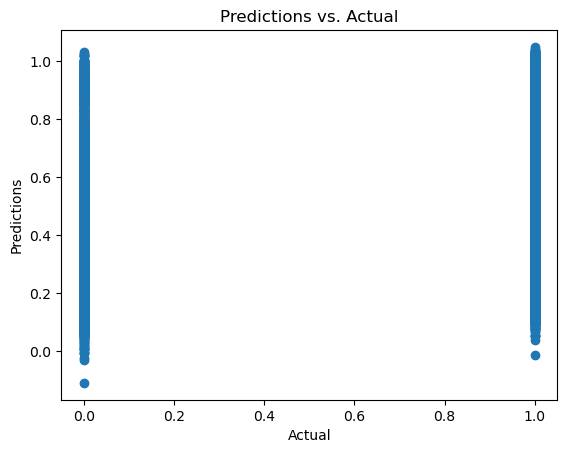

In [113]:
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
model.summary()

predict = model.predict(x_test)

plt.scatter(y_test, predict)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()


In [91]:
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Binomial()).fit()
glm_binom_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             HAS INJURY   No. Observations:                85728
Model:                            GLM   Df Residuals:                    85665
Model Family:                Binomial   Df Model:                           62
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -47086.
Date:                Thu, 12 Oct 2023   Deviance:                       94173.
Time:                        12:09:08   Pearson chi2:                 8.59e+04
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2244
Covariance Type:            nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
YEAR                                                                                    0.0906      0.006     15.602      0.000       0.079       0.102
CRASH HOUR                                                                              0.0362      0.001     28.160      0.000       0.034       0.039
DAY OF WEEK                                                                            -0.0146      0.004     -3.601      0.000      -0.022      -0.007
CARS INVOLVED                                                                        -154.9443    788.977     -0.196      0.844   -1701.311    1391.423
BOROUGH_BRONX                                                                         -25.8180    131.496     -0.196      0.844    -283.546     231.910
BOROUGH_BROOKLYN                                                                      -25.6566    131.496     -0.195      0.845    -283.384     232.071
BOROUGH_MANHATTAN                                                                     -25.6816    131.496     -0.195      0.845    -283.410     232.046
BOROUGH_QUEENS                                                                        -25.9488    131.496     -0.197      0.844    -283.677     231.779
BOROUGH_STATEN ISLAND                                                                 -26.1388    131.496     -0.199      0.842    -283.867     231.589
BOROUGH_UNKNOWN                                                                       -25.7005    131.496     -0.195      0.845    -283.428     232.027
CONTRIBUTING FACTOR VEHICLE 1_Accelerator Defective                                    -2.8429    920.401     -0.003      0.998   -1806.796    1801.110
CONTRIBUTING FACTOR VEHICLE 1_Aggressive Driving/Road Rage                             -2.1883    920.401     -0.002      0.998   -1806.141    1801.765
CONTRIBUTING FACTOR VEHICLE 1_Alcohol Involvement                                      -3.2765    920.401     -0.004      0.997   -1807.230    1800.677
CONTRIBUTING FACTOR VEHICLE 1_Animals Action                                           -4.0600    920.401     -0.004      0.996   -1808.013    1799.893
CONTRIBUTING FACTOR VEHICLE 1_Backing Unsafely                                         -2.2547    920.401     -0.002      0.998   -1806.208    1801.698
CONTRIBUTING FACTOR VEHICLE 1_Brakes Defective                                         -3.2003    920.401     -0.003      0.997   -1807.153    1800.753
CONTRIBUTING FACTOR VEHICLE 1_Cell Phone (hand-Held)                                   -2.1514    920.401     -0.002      0.998   -1806.105    1801.802
CONTRIBUTING FACTOR VEHICLE 1_Cell Phone (h

In [92]:
logreg = LogisticRegression(random_state=16)
logreg.fit(x_train, y_train)

print('Model Coefficients:', logreg.coef_)
print()
print('Intercept:', logreg.intercept_)
coef = pd.DataFrame(logreg.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined 

Model Coefficients: [[-4.39650167e-05  2.50276005e-02 -1.56233116e-02 -3.17239167e-03
   4.97098703e-02  3.61648705e-01  1.96066487e-01 -2.22681629e-01
  -3.52331423e-01 -3.55844022e-02 -8.38408907e-03  8.65185092e-02
  -2.89221674e-01 -1.37020832e-01  2.22671788e-01 -8.10100318e-02
   6.62910315e-03  8.45601917e-04  4.40094019e-01 -1.12211987e-01
  -2.67646704e-02  2.78050845e-03 -5.71991640e-04 -7.95457558e-03
   2.87900499e+00 -1.32392523e-02 -6.70074231e-03 -1.03334967e-01
   1.06097979e-01 -3.28553646e-04  7.22158082e-02 -6.74272894e-03
   9.01604904e-02 -2.53742750e-01 -9.53925125e-04 -3.29258818e-03
  -1.07662410e+00 -6.67742510e-03 -2.61252657e-01  3.08938966e-03
  -1.03442963e-01 -5.56552883e-03 -6.09459944e-02 -3.17278810e-01
   7.47716809e-01  7.24455232e-03  2.86885156e-03 -2.36431978e-01
  -7.57188208e-03 -6.45338629e-02  2.21306708e-05  4.30079409e-03
  -7.05958353e-02 -1.03936974e-02 -1.19385624e-02  1.51535594e-01
  -5.82203688e-02 -1.59533409e-02 -1.03171261e-01 -1.458

,Columns,Coefficients
0,YEAR,-0.000044
1,CRASH HOUR,0.025028
2,DAY OF WEEK,-0.015623
3,CARS INVOLVED,-0.003172
4,BOROUGH_BRONX,0.049710
...,...,...
59,CONTRIBUTING FACTOR VEHICLE 1_Unspecified,-1.458473
60,CONTRIBUTING FACTOR VEHICLE 1_Using On Board N...,-0.006128
61,CONTRIBUTING FACTOR VEHICLE 1_Vehicle Vandalism,-0.008167
62,CONTRIBUTING FACTOR VEHICLE 1_View Obstructed/...,0.107868


# MODELING Poisson - Number of Injuries

In [102]:
poisson_data_injury = mvc_1_car.copy()
poisson_data_injury = pd.get_dummies(poisson_data_injury, columns = ['BOROUGH', 'CONTRIBUTING FACTOR VEHICLE 1'])
poisson_data_injury.drop(['VEHICLE TYPE CODE 1', 'HAS INJURY', 'NUMBER OF PERSONS KILLED', 'HAS FATALITY'], axis=1, inplace=True)
poisson_data_injury.head()

,NUMBER OF PERSONS INJURED,YEAR,CRASH HOUR,DAY OF WEEK,CARS INVOLVED,BOROUGH_BRONX,BOROUGH_BROOKLYN,BOROUGH_MANHATTAN,BOROUGH_QUEENS,BOROUGH_STATEN ISLAND,...,CONTRIBUTING FACTOR VEHICLE 1_Traffic Control Device Improper/Non-Working,CONTRIBUTING FACTOR VEHICLE 1_Traffic Control Disregarded,CONTRIBUTING FACTOR VEHICLE 1_Turning Improperly,CONTRIBUTING FACTOR VEHICLE 1_Unsafe Lane Changing,CONTRIBUTING FACTOR VEHICLE 1_Unsafe Speed,CONTRIBUTING FACTOR VEHICLE 1_Unspecified,CONTRIBUTING FACTOR VEHICLE 1_Using On Board Navigation Device,CONTRIBUTING FACTOR VEHICLE 1_Vehicle Vandalism,CONTRIBUTING FACTOR VEHICLE 1_View Obstructed/Limited,CONTRIBUTING FACTOR VEHICLE 1_Windshield Inadequate
1,1.0,2022,11,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,2021,9,5,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,2021,8,1,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13,0.0,2021,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16,4.0,2021,20,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# Create X - assign independent variables, dependent variable, respectively
x = poisson_data_injury.loc[:, poisson_data_injury.columns != 'NUMBER OF PERSONS INJURED']

# define the target
y = pd.DataFrame(poisson_data_injury['NUMBER OF PERSONS INJURED'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [104]:
x_train = sm.add_constant(x_train)
glm_binom_model = sm.GLM(y_train, x_train, family=sm.families.Poisson()).fit()
glm_binom_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Generalized Linear Model Regression Results                     
=====================================================================================
Dep. Variable:     NUMBER OF PERSONS INJURED   No. Observations:                85728
Model:                                   GLM   Df Residuals:                    85665
Model Family:                        Poisson   Df Model:                           62
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:                -66760.
Date:                       Thu, 12 Oct 2023   Deviance:                       61503.
Time:                               12:16:03   Pearson chi2:                 7.16e+04
No. Iterations:                           21   Pseudo R-squ. (CS):             0.1242
Covariance Type:                   nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
YEAR                                                                                    0.0459      0.004     12.511      0.000       0.039       0.053
CRASH HOUR                                                                              0.0174      0.001     20.759      0.000       0.016       0.019
DAY OF WEEK                                                                            -0.0035      0.003     -1.357      0.175      -0.009       0.002
CARS INVOLVED                                                                         -79.4522    227.764     -0.349      0.727    -525.862     366.958
BOROUGH_BRONX                                                                         -13.2337     37.961     -0.349      0.727     -87.635      61.168
BOROUGH_BROOKLYN                                                                      -13.1658     37.961     -0.347      0.729     -87.567      61.236
BOROUGH_MANHATTAN                                                                     -13.1995     37.961     -0.348      0.728     -87.601      61.202
BOROUGH_QUEENS                                                                        -13.3088     37.961     -0.351      0.726     -87.710      61.093
BOROUGH_STATEN ISLAND                                                                 -13.3829     37.961     -0.353      0.724     -87.785      61.019
BOROUGH_UNKNOWN                                                                       -13.1615     37.961     -0.347      0.729     -87.563      61.240
CONTRIBUTING FACTOR VEHICLE 1_Accelerator Defective                                    -0.8776    265.625     -0.003      0.997    -521.493     519.737
CONTRIBUTING FACTOR VEHICLE 1_Aggressive Driving/Road Rage                             -0.6636    265.625     -0.002      0.998    -521.279     519.951
CONTRIBUTING FACTOR VEHICLE 1_Alcohol Involvement                                      -1.1486    265.625     -0.004      0.997    -521.764     519.466
CONTRIBUTING FACTOR VEHICLE 1_Animals Action                                           -1.8674    265.625     -0.007      0.994    -522.482     518.748
CONTRIBUTING FACTOR VEHICLE 1_Backing Unsafely                                         -0.7781    265.625     -0.003      0.998    -521.393     519.837
CONTRIBUTING FACTOR VEHICLE 1_Brakes Defective                                         -1.0497    265.625     -0.004      0.997    -521.665     519.565
CONTRIBUTING FACTOR VEHICLE 1_Cell Phone (hand-Held)                                   -0.5712    265.625     -0.002  

In [105]:
poisson_reg = PoissonRegressor()
poisson_reg.fit(x_train, y_train)

print('Model Coefficients:', poisson_reg.coef_)
print()
print('Intercept:', poisson_reg.intercept_)
coef = pd.DataFrame(poisson_reg.coef_.T, columns=['Coefficients'])
cols = pd.DataFrame(x.columns, columns=['Columns'])
joined = pd.concat([cols['Columns'], coef['Coefficients']], axis=1)
joined 

Model Coefficients: [-8.82910859e-05  1.79457321e-02 -5.38119899e-03 -2.86179180e-05
 -6.16771592e-03 -3.71642759e-04  4.15985754e-03 -6.14070416e-03
 -2.19677793e-03  1.06883653e-02  8.82133777e-05  1.42353653e-03
 -9.29079745e-05 -5.91791844e-04  3.88598418e-03  1.10351781e-04
  1.02285754e-04  5.90893567e-06  3.21005442e-02  1.30204236e-03
  1.56521297e-05  7.26418418e-05  2.21789557e-07 -1.18188014e-05
  3.71306055e-02  9.90787664e-05  5.04836810e-04 -1.89264402e-04
  1.08541883e-03 -1.96729317e-07  9.64546679e-04  3.86587940e-06
  8.82970173e-04 -8.51543604e-04 -3.07363399e-06  1.97197979e-06
 -4.28740457e-03  2.38663772e-04 -1.21189247e-03  2.08764969e-04
 -2.27515320e-05  7.16093784e-04  1.64636477e-04 -1.01367308e-04
  6.52695728e-03  1.07227727e-04  3.88438250e-05  1.40733346e-03
 -3.43624914e-05  1.80559643e-04  1.69170624e-06  3.59705806e-05
  1.97222341e-05 -5.02293424e-05 -3.53041326e-05  2.03535375e-03
  5.43434455e-04  3.19189089e-04  4.78068418e-03 -9.13905429e-02
 -2.5

,Columns,Coefficients
0,YEAR,-0.000088
1,CRASH HOUR,0.017946
2,DAY OF WEEK,-0.005381
3,CARS INVOLVED,-0.000029
4,BOROUGH_BRONX,-0.006168
...,...,...
59,CONTRIBUTING FACTOR VEHICLE 1_Unspecified,-0.091391
60,CONTRIBUTING FACTOR VEHICLE 1_Using On Board N...,-0.000025
61,CONTRIBUTING FACTOR VEHICLE 1_Vehicle Vandalism,-0.000038
62,CONTRIBUTING FACTOR VEHICLE 1_View Obstructed/...,0.001802


In [106]:
poisson_predictions = poisson_reg.predict(y_test)

plt.scatter(y_test, poisson_predictions)
plt.title('Predictions vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- NUMBER OF PERSONS INJURED
Feature names seen at fit time, yet now missing:
- BOROUGH_BRONX
- BOROUGH_BROOKLYN
- BOROUGH_MANHATTAN
- BOROUGH_QUEENS
- BOROUGH_STATEN ISLAND
- ...
